---
# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# uncomment next line when running code in jupyter notebook
%matplotlib inline
import glob
import matplotlib.cm as cm



### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
class Points:
    """ Static class """
    objpoints = []  # will store 3D grid reference coordinates
    imgpoints = []  # will store 2D corners coordinates found in the calibration image



In [3]:
def find_corner_coordinates_and_map_to_reference_chessboard():
    """
    Create 9 col x 6 row grid reference coordinates aka 3D objpoints.
    Locate corners surrounded by 4 squares in calibration images and store coordinates aka 2D imgpoints
    """
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    images = glob.glob('camera_cal/calibration*.jpg')
    for img in images:
        img = cv2.imread(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        if ret:
            Points.imgpoints.append(corners)
            Points.objpoints.append(objp)
            # print("Calibration grid setup done.")



In [4]:
def calculate_camera_distortion_coefficients(img, objpts, imgpts):
    """
    aka calibrate camera
    :param img: to calculate against
    :param objpts: 3D grid coordinates from Points class
    :param imgpts: 2D image corner coordinates from Points class
    :return: camera_matrix, distortion_coefficients
    """
    img_size = (img.shape[1], img.shape[0])
    return_value, camera_matrix, distortion_coefficients, rotation_vectors, \
    translation_vectors = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
    # print("Distortion coefficients calculated.")
    return camera_matrix, distortion_coefficients



In [5]:
find_corner_coordinates_and_map_to_reference_chessboard()

calibration_img = cv2.imread("camera_cal/calibration1.jpg")
c_matrix, dist_coeff = calculate_camera_distortion_coefficients(calibration_img, Points.objpoints,
                                                                Points.imgpoints)



### 2. Apply a distortion correction to raw images.

In [6]:
def undistort_image(img, mtx, dist):
    """
    Undistort the image.
    :param img: image
    :param mtx: camera attributes matrix
    :param dist: distortion coefficients
    :return: undistorted image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # print("Image undistorted.")
    return undist



In [7]:
def compare_raw_distorted_against_undistorted_images(raw_1, undist_1, raw_2, undist_2):
    """
    Side-by-side visual comparison test.
    :param raw_1: distorted image
    :param raw_2: 2nd distorted image
    :param undist_1: undistorted image
    :param undist_2: 2nd undistorted image
    """
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(15)

    fig.add_subplot(2, 2, 1)
    plt.title("Distorted Images")
    plt.imshow(raw_1, cmap='gray')
    fig.add_subplot(2, 2, 2)
    plt.title("Undistorted Images")
    plt.imshow(undist_1, cmap='gray')
    fig.add_subplot(2, 2, 3)
    plt.imshow(raw_2)
    fig.add_subplot(2, 2, 4)
    plt.imshow(undist_2)

    # IMPORTANT : uncomment when running from Jupyter Notebook
    plt.show()

    print("Side-by-side views done.")



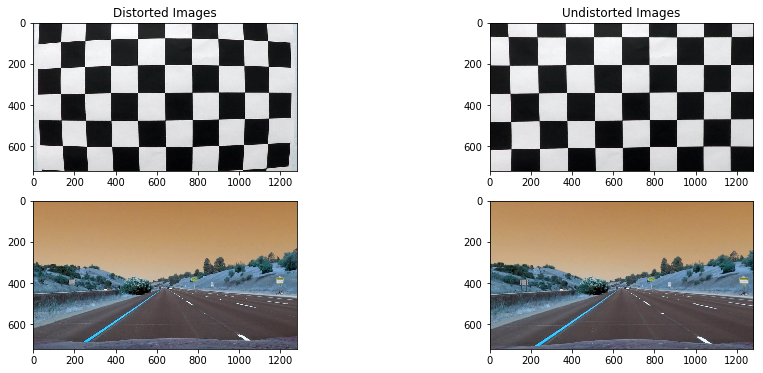

Side-by-side views done.


In [8]:
# calibration images
undistorted_calibration_img = undistort_image(calibration_img, c_matrix, dist_coeff)
cv2.imwrite('camera_cal/undist_calibration1.jpg', undistorted_calibration_img)

# straight lane line images
straight_lines_image = cv2.imread('test_images/straight_lines1.jpg')
# straight_lines_image = cv2.imread('test_images/straight_lines2.jpg')
undistorted_straight_lines = undistort_image(straight_lines_image, c_matrix, dist_coeff)
cv2.imwrite('output_images/undistorted_straight_lines1.jpg',
            undistorted_straight_lines)
# cv2.imwrite('output_images/undistorted_straight_lines2.jpg', undistorted_straight_lines)

# View results
compare_raw_distorted_against_undistorted_images(calibration_img, undistorted_calibration_img,
                                                 straight_lines_image,
                                                 undistorted_straight_lines)



### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [9]:
def sobel_gradient_direction(copy_of_colour_image, sobel_kernel=3):
    """
    Rescale absolute sobel gradients in x direction.
    REMOVED : Define a function that applies Sobel x and y, then computes the direction (radians) of the gradient.
    :param copy_of_colour_image: to process
    :param sobel_kernel: window size for calculating x and y gradients, cv2.Sobel default = 3 if no param
    :return:
    """
    gray = cv2.cvtColor(copy_of_colour_image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # Note : from video lesson code, couldn't get np.arctan2() to produce usable results, so simply rescaling instead.
    # sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # abs_grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))  # radians aka approx. angles
    abs_grad_dir = np.uint8(
        (np.absolute(sobel_x)) / np.max(np.absolute(sobel_x)) * 255)  # rescale down to 8 bit integer
    # print("np.absolute(sobel_x) :", np.absolute(sobel_x))
    # print("np.max(np.absolute(sobel_x) :", np.max(np.absolute(sobel_x)))
    # print("abs_grad_dir :", abs_grad_dir)
    return abs_grad_dir



In [10]:
def extract_saturation_channel(colour_img):
    """
    Convert colour image into HLS channels and extract saturation channel.
    :param colour_img: image to extract s channel ndarray from
    :return: image saturation channel ndarray
    """
    hls = cv2.cvtColor(colour_img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:, :, 2]  # aka 3rd channel
    # print("saturation channel extracted :", s_channel)
    return s_channel



In [11]:
def view_transformed_images(result_array):
    """
    View the images output from the transformation pipeline.
    :param result_array : Directional, S channel, Yellows, binary thresholded images.
    """
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(15)

    fig.add_subplot(2, 2, 1)
    plt.title("Gradient Saturation Binary")
    # gradient_saturation_binary_image
    plt.imshow(result_array[0])
    fig.add_subplot(2, 2, 2)
    plt.title("Gradient Saturation Colour Binary")
    # combined_saturation_gradient_colour_binary_image
    plt.imshow(result_array[1], cmap='gray')

    # IMPORTANT : uncomment when running from Jupyter Notebook
    # plt.show()

    print("Binary side-by-side views done.")



In [12]:
def colour_image_transformation_pipeline(colour_image, sat_thresh=(180, 255), sobel_threshold_range=(40, 100),
                                         rgb_thresh=(200, 255)):
    """
    Image information extraction pipeline.
    :param colour_image: input image
    :param sat_thresh: saturation threshold range
    :param sobel_threshold_range: gradient direction threshold range
    :param rgb_thresh: colour intensity threshold range
    :return: grad_sat_bin_image, stacked_s_g_c_bin_image
    """
    copy_of_colour_image = np.copy(colour_image)

    # Extract S channel
    saturation_channel = extract_saturation_channel(copy_of_colour_image)

    # Calculate line directions
    sobel_gradient_directions = sobel_gradient_direction(copy_of_colour_image)

    # Threshold gradient
    sobel_binary = np.zeros_like(sobel_gradient_directions)
    sobel_binary[(sobel_gradient_directions >= sobel_threshold_range[0]) & (
        sobel_gradient_directions <= sobel_threshold_range[1])] = 1

    # Threshold RGB channel for range (200, 255) aka yellows
    yellow = copy_of_colour_image[:, :, 0]
    yellow_binary = np.zeros_like(yellow)
    yellow_binary[(yellow > rgb_thresh[0]) & (yellow <= rgb_thresh[1])] = 1

    # Threshold colour intensity
    saturation_binary = np.zeros_like(saturation_channel)
    saturation_binary[(saturation_channel >= sat_thresh[0]) & (saturation_channel <= sat_thresh[1])] = 1

    # Stack dimensions
    grad_sat_bin_img = np.dstack((np.zeros_like(sobel_binary), sobel_binary, saturation_binary))
    # print("grad_sat_bin_img.shape :", grad_sat_bin_img.shape)
    stacked_s_g_c_bin_img = np.zeros_like(sobel_binary)
    stacked_s_g_c_bin_img[(saturation_binary == 1) | (sobel_binary == 1) | (yellow_binary == 1)] = 1
    # print("stacked_s_g_c_bin_img.shape :", stacked_s_g_c_bin_img.shape)
    # print("colour_image_transformation_pipeline processing done")
    return grad_sat_bin_img, stacked_s_g_c_bin_img



Binary side-by-side views done.


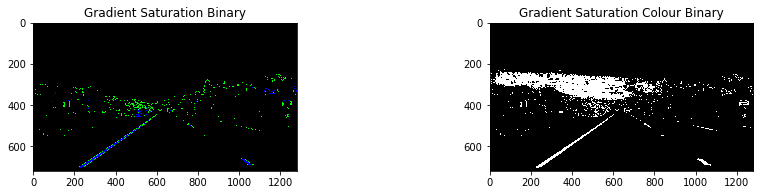

In [13]:
# Extract information from image
result = colour_image_transformation_pipeline(undistorted_straight_lines)

# Save outputs
plt.imsave('output_images/colour_binary_straight_lines1.png',
           np.array(result[0]))
plt.imsave('output_images/stacked_binary_straight_lines1.png',
           np.array(result[1]),
           cmap=cm.gray)

# View outputs
view_transformed_images(result)



### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [14]:
def view_polygon_and_warped_images(polygon_overlay_image, warped_polygon_overlay_image):
    """
    View the undistored image with polygon lane line and warped image from overhead viewpoint with
        destination points drawn.
    :param polygon_overlay_image: image with overlay
    :param warped_polygon_overlay_image: overhead view of image with overlay
    """
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(15)

    fig.add_subplot(2, 2, 1)
    plt.title("Undistorted image with polygon overlay")
    plt.imshow(polygon_overlay_image)
    fig.add_subplot(2, 2, 2)
    plt.title("Warped image from overhead viewpoint")
    plt.imshow(warped_polygon_overlay_image)

    # IMPORTANT : uncomment when running from Jupyter Notebook
    # plt.show()

    # print("Polygon and warped side-by-side views done.")



In [15]:
def define_source_polygon():
    """
    Define 4 corners of polygon region of undistorted image.
    """
    global source_transformation
    source_transformation = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    # print("source_transformation polygon defined :", source_transformation)



In [16]:
def define_destination_polygon():
    """
    Define 4 corners of polygon region to warp transform onto.
    """
    global destination_transformation
    destination_transformation = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    # print("destination_transformation polygon defined :", destination_transformation)



In [17]:
def warp_perspective_to_top_down(src, img, dst):
    """
    Calculate the inversed transformation matrix and warped top down transform image
    :param src: source points where warp transforms from
    :param img: stacked binary thresholded image that includes saturation, gradient direction, colour intensity
    :param dst: destination points where warp transforms to
    :return: the transformation matrix inversed, warped top-down binary image
    """
    transformation_matrix = cv2.getPerspectiveTransform(src, dst)  # the transform matrix
    transformation_matrix_inverse = cv2.getPerspectiveTransform(dst, src)  # the transform matrix inverse
    warped_to_top_down = cv2.warpPerspective(img, transformation_matrix,
                                             img_size)  # warp image to a top-down view
    # print("Perspective warp done.")
    return transformation_matrix_inverse, warped_to_top_down



In [18]:
def polygon():
    """
    Create green polygon and overlay on undistorted image.
    """
    global polygon_undistored_image
    polygon_undistored_image = cv2.line(undistorted_straight_lines, (240, 700), (610, 440), [0, 255, 0], 3)
    polygon_undistored_image = cv2.line(undistorted_straight_lines, (240, 700), (1080, 700), [0, 255, 0], 3)
    polygon_undistored_image = cv2.line(undistorted_straight_lines, (1080, 700), (670, 440), [0, 255, 0], 3)
    polygon_undistored_image = cv2.line(undistorted_straight_lines, (610, 440), (670, 440), [0, 255, 0], 3)
    # print("Green polygon defined : ", polygon_undistored_image)



### 5. Detect lane pixels and fit to find the lane boundary.

source_transformation points : [[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
destination_transformation points : [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]
top_down_warped_binary_polygon.shape : (720, 1280, 3)
top_down_warped_binary_stacked.shape : (720, 1280)


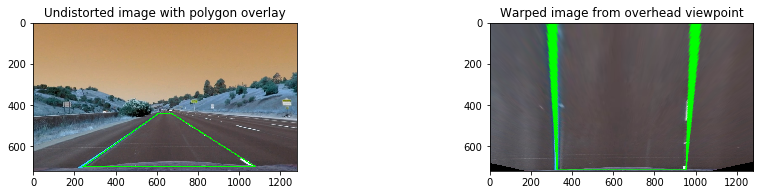

In [51]:
# Get image 2D size
# print("undistorted_straight_lines.shape : ", undistorted_straight_lines.shape)
img_size = (undistorted_straight_lines.shape[1], undistorted_straight_lines.shape[0])

# Set 4 corners of warp source polygon
define_source_polygon()
print("source_transformation points :", source_transformation)

# Set 4 corners of warp destination polygon
define_destination_polygon()
print("destination_transformation points :", destination_transformation)

# Create polygon overlayed onto undistorted image
polygon()

# Engage warp drive :)
matrix_transform_inversed, top_down_warped_binary_polygon = warp_perspective_to_top_down(source_transformation,
                                                                                         polygon_undistored_image,
                                                                                         destination_transformation)

print("top_down_warped_binary_polygon.shape :", top_down_warped_binary_polygon.shape)
matrix_transform_inversed_stacked, top_down_warped_binary_stacked = warp_perspective_to_top_down(
    source_transformation,
    result[1],
    destination_transformation)
print("top_down_warped_binary_stacked.shape :", top_down_warped_binary_stacked.shape)

# Store output
cv2.imwrite('output_images/lined_image_straight_lines2.jpg', polygon_undistored_image)
cv2.imwrite('output_images/warped_straight_lines2.jpg', top_down_warped_binary_polygon)

# View output
view_polygon_and_warped_images(polygon_undistored_image, top_down_warped_binary_polygon)


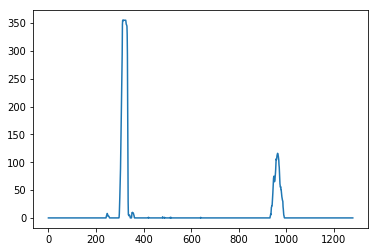

In [20]:
histogram = np.sum(top_down_warped_binary_stacked[top_down_warped_binary_stacked.shape[0] // 2:, :], axis=0)
plt.plot(histogram)



### 6.1 Determine the curvature of the lane and ...

In [21]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        self.failed_sanity_check_count = None



In [22]:
def get_offset_from_center(right_x, left_x, midpoint):
    """
    Using the warp histogram x points, calculate the camera's (aka car's) position, relative to lane centre.
    Note 1 : minimum USA lane width for interstate highways is 3.7 metres.
    See https://en.wikipedia.org/wiki/Interstate_Highway_standards
    Note 2 : image 2D is 780 (y) x 1280 (x) pixels and  lane is approx. 800 (x) pixels wide at base
    :param right_x: right lane spike max x value
    :param left_x: right lane spike max x value
    :param midpoint: calculated mid-point value between left_x and right_x
    :return: car offset from lane centre
    """

    return (3.7 / 700) * abs(((right_x - left_x) / 2) + left_x - midpoint)  # 3.7 m / 700 px == metres per pixel



In [23]:
def find_key_lane_points_along_x(binary_warped):
    """
    Use max points from histogram spikes, calculate left, mid and right x points.
    :param binary_warped: top-down perspective of lane lines to operate on
    :return: left, mid and right x points
    """
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # print("histogram.shape : ", histogram.shape)  # (1280,)
    midpoint = np.int(histogram.shape[0] / 2)
    # print("midpoint :", midpoint)  # 640
    left_x_base = np.argmax(histogram[:midpoint])  # get max point between left and middle
    # print("left_x_base :", left_x_base)  # e.g. 290 and 312
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint  # get max point between middle and right
    # print("right_x_base :", right_x_base)  # e.g. 983 and 963
    return left_x_base, midpoint, right_x_base



In [24]:
def find_active_x_y_pixels(binary_warped_img):
    """
    Capture positions of active pixels along y and x axes from top-down perspective image
    :param binary_warped_img: top-down perspective of lane lines to operate on
    :return: active pixels along y and x axes
    """
    nonzero = binary_warped_img.nonzero()
    nonzero_y = np.array(nonzero[0])  # y axis pixels
    nonzero_x = np.array(nonzero[1])  # x axis pixels
    return nonzero_x, nonzero_y



In [25]:
def find_left_and_right_sliding_windows_boundaries(binary_warped, left_x_current, right_x_current, window,
                                                   window_height, window_width_margin):
    """
    Find left and right sliding windows boundaries
    :param binary_warped: top-down perspective of lane lines to operate on
    :param left_x_current: left x spike
    :param right_x_current: right x spike
    :param window: index in window iteration range
    :param window_height: sliding window heigh
    :param window_width_margin: margin to adjust +/- sliding window's width
    :return: boundary values
    """
    window_y_low_boundary = binary_warped.shape[0] - (window + 1) * window_height
    window_y_high_boundary = binary_warped.shape[0] - window * window_height
    window_x_left_side_low_boundary = left_x_current - window_width_margin
    window_x_left_side_high_boundary = left_x_current + window_width_margin
    window_x_right_side_low_boundary = right_x_current - window_width_margin
    window_x_right_side_high_boundary = right_x_current + window_width_margin
    return window_x_left_side_high_boundary, window_x_left_side_low_boundary, window_x_right_side_high_boundary, window_x_right_side_low_boundary, window_y_high_boundary, window_y_low_boundary



In [26]:
def find_active_x_y_pxs_in_window(active_pxs_x, active_pxs_y, window_x_left_side_high_boundary,
                                  window_x_left_side_low_boundary, window_x_right_side_high_boundary,
                                  window_x_right_side_low_boundary, window_y_high_boundary,
                                  window_y_low_boundary):
    """
    Find active x y pixels in sliding window
    :param active_pxs_x: non-zero pixels in x axis
    :param active_pxs_y: non-zero pixels in y axis
    :param window_x_left_side_high_boundary: a sliding window x position
    :param window_x_left_side_low_boundary: a sliding window x position
    :param window_x_right_side_high_boundary: a sliding window x position
    :param window_x_right_side_low_boundary: a sliding window x position
    :param window_y_high_boundary: a sliding window y position
    :param window_y_low_boundary: a sliding window y position
    :return:
    """
    active_left_pxs_indices = \
        ((active_pxs_y >= window_y_low_boundary) & (active_pxs_y < window_y_high_boundary) & (
            active_pxs_x >= window_x_left_side_low_boundary) & (
             active_pxs_x < window_x_left_side_high_boundary)).nonzero()[0]
    active_right_pxs_indices = \
        ((active_pxs_y >= window_y_low_boundary) & (active_pxs_y < window_y_high_boundary) & (
            active_pxs_x >= window_x_right_side_low_boundary) & (
             active_pxs_x < window_x_right_side_high_boundary)).nonzero()[0]
    return active_left_pxs_indices, active_right_pxs_indices



In [27]:
def recentre_next_sliding_window_back_to_the_mean(active_left_pxs_indices, active_pxs_x,
                                                  active_right_pxs_indices, left_x_spike_current,
                                                  min_pxs_to_recentre_window, right_x_spike_current):
    """
    Check if line is curving outside of min pixels threshold, then recentre next sliding window in loop.
    :param active_left_pxs_indices: left line
    :param active_pxs_x: all active pixes, left and right
    :param active_right_pxs_indices: right line
    :param left_x_spike_current: max left x position
    :param min_pxs_to_recentre_window: threshold trigger value
    :param right_x_spike_current: max right x position
    :return: new left and right x positions
    """
    if len(active_left_pxs_indices) > min_pxs_to_recentre_window:
        left_x_spike_current = np.int(np.mean(active_pxs_x[active_left_pxs_indices]))
    if len(active_right_pxs_indices) > min_pxs_to_recentre_window:
        right_x_spike_current = np.int(np.mean(active_pxs_x[active_right_pxs_indices]))

    return left_x_spike_current, right_x_spike_current



In [28]:
def group_active_x_y_pixels(active_pxs_x, active_pxs_y, left_lane_pxs_indices,
                            right_lane_pxs_indices):
    """
    Group left and right line pixel positions
    :param active_pxs_x: all active pixels in x direction
    :param active_pxs_y: all active pixels in y direction
    :param left_lane_pxs_indices: all active left line pixels
    :param right_lane_pxs_indices: all active right line pixels
    :return: grouped active pixels in x, y directions for left, right lines
    """
    left_x = active_pxs_x[left_lane_pxs_indices]
    left_y = active_pxs_y[left_lane_pxs_indices]
    right_x = active_pxs_x[right_lane_pxs_indices]
    right_y = active_pxs_y[right_lane_pxs_indices]
    return left_x, left_y, right_x, right_y



In [29]:
def calc_deg_2_polynomial_with_left_right_fit_x_coefficients(binary_warped, left_fit,
                                                             right_fit):
    """
    e.g. p(x) = p[0]        * x      **deg+ p[1]        * x      + p[deg]
    left_fitx = left_fit[0] * y_axis ** 2 + left_fit[1] * y_axis + left_fit[2]

    :param binary_warped: top-down perspective of lane lines to operate on
    :param left_fit: vector of left fit coefficients ('p' above) that minimises the squared error
    :param right_fit: vector of right fit coefficients ('p' above) that minimises the squared error
    :return: best fit left and right lines
    """
    y_axis = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])  # (0 ... 719)
    #    p(x) = p[0]        * x     **deg+ x           * deg   + p[deg]
    left_fit_x = left_fit[0] * y_axis ** 2 + left_fit[1] * y_axis + left_fit[2]
    right_fit_x = right_fit[0] * y_axis ** 2 + right_fit[1] * y_axis + right_fit[2]
    return left_fit_x, y_axis, right_fit_x



In [30]:
def setup_lines(binary_warped, left_line, right_line):
    """
    Apply iterative sliding window technique to setup lines
    :param binary_warped: top-down perspective of lane lines to operate on
    :param left_line: Line object to modify
    :param right_line: Line object to modify
    :return: modified lines, vehicle offset from lane centre, y_axis number series 0 - 719
    """
    # print("binary_warped.shape : ", binary_warped.shape)  # (720, 1280)
    # print("binary_warped : ", binary_warped)  # [[0 0 0 ..., 0 0 0] ... [0 0 0 ..., 0 0 0]]

    # Create the output image template
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # print("out_img.shape :", out_img.shape)  # (720, 1280, 3)
    # print("out_img : ", out_img)  # [ [[0 0 0] [0 0 0] [0 0 0] ..., 0 0 0] [0 0 0] [0 0 0]] ... ]

    # Find spiked and calculate key x points from histogram
    left_x_spike_base, midpoint, right_x_spike_base = find_key_lane_points_along_x(binary_warped)
    offset_from_center = get_offset_from_center(right_x_spike_base, left_x_spike_base, midpoint)
    # print("offset_from_center :", offset_from_center)  # 0.0185 and 0.0132142857143

    # Set the number of sliding windows
    total_sliding_windows = 9

    # Set the height of sliding windows as a proportion total image height
    window_height = np.int(binary_warped.shape[0] / total_sliding_windows)

    # Capture positions of active pixels
    active_pxs_x, active_pxs_y = find_active_x_y_pixels(binary_warped)

    # Set current left, right positions. This will be updated for each window
    left_x_spike_current = left_x_spike_base
    right_x_spike_current = right_x_spike_base

    # Set the width of the windows +/- margin
    window_width_margin = 50

    # Set threshold number of pixels before triggering sliding window recenter
    min_pxs_to_recentre_window = 30

    # Create empty lists to receive left and right lane pixel indices
    left_lane_pxs_indices = []
    right_lane_pxs_indices = []

    # Loop through and process each sliding window
    for window in range(total_sliding_windows):
        # Find all window boundaries
        window_x_left_side_high_boundary, window_x_left_side_low_boundary, window_x_right_side_high_boundary, window_x_right_side_low_boundary, window_y_high_boundary, window_y_low_boundary = find_left_and_right_sliding_windows_boundaries(
            binary_warped, left_x_spike_current, right_x_spike_current, window, window_height,
            window_width_margin)

        # Draw the sliding windows onto the output image
        cv2.rectangle(out_img, (window_x_left_side_low_boundary, window_y_low_boundary),
                      (window_x_left_side_high_boundary, window_y_high_boundary), (0, 255, 0), 2)
        cv2.rectangle(out_img, (window_x_right_side_low_boundary, window_y_low_boundary),
                      (window_x_right_side_high_boundary, window_y_high_boundary), (0, 255, 0), 2)

        # Find active pixels for x, y within this sliding window
        active_left_pxs_indices, active_right_pxs_indices = find_active_x_y_pxs_in_window(active_pxs_x,
                                                                                          active_pxs_y,
                                                                                          window_x_left_side_high_boundary,
                                                                                          window_x_left_side_low_boundary,
                                                                                          window_x_right_side_high_boundary,
                                                                                          window_x_right_side_low_boundary,
                                                                                          window_y_high_boundary,
                                                                                          window_y_low_boundary)

        # Append line indices to lists
        left_lane_pxs_indices.append(active_left_pxs_indices)
        right_lane_pxs_indices.append(active_right_pxs_indices)

        # Recentre next window to the mean position
        left_x_spike_current, right_x_spike_current = recentre_next_sliding_window_back_to_the_mean(
            active_left_pxs_indices, active_pxs_x, active_right_pxs_indices, left_x_spike_current,
            min_pxs_to_recentre_window, right_x_spike_current)

    # Concatenate the arrays of indices
    left_lane_pxs_indices = np.concatenate(left_lane_pxs_indices)
    right_lane_pxs_indices = np.concatenate(right_lane_pxs_indices)

    # Group left and right line pixel positions
    left_x_active_pxs, left_y_active_pxs, right_x_active_pxs, right_y_active_pxs = group_active_x_y_pixels(
        active_pxs_x,
        active_pxs_y,
        left_lane_pxs_indices,
        right_lane_pxs_indices)

    # Update Line objects attributes
    left_line.allx = left_x_active_pxs
    left_line.ally = left_y_active_pxs
    right_line.allx = right_x_active_pxs
    right_line.ally = right_y_active_pxs

    # Fit a degree 2 polynomial through the left and right active pixels
    left_fit = np.polyfit(left_y_active_pxs, left_x_active_pxs, 2)
    right_fit = np.polyfit(right_y_active_pxs, right_x_active_pxs, 2)

    # Update Line objects attributes
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit

    # Best fit the left and right lines
    best_left_fit_x, y_axis_values, best_right_fit_x = calc_deg_2_polynomial_with_left_right_fit_x_coefficients(
        binary_warped,
        left_fit,
        right_fit)

    left_line.recent_xfitted.append(best_left_fit_x)
    right_line.recent_xfitted.append(best_right_fit_x)
    left_line.bestx = best_left_fit_x
    right_line.bestx = best_right_fit_x
    return offset_from_center, left_line, right_line, y_axis_values



In [31]:
def draw_polynomial_line(points):
    """
    Use the recently fitted line points with cv2.line() to iteratively draw a yellow degree-2 polynomial line
    :param points: recent, best fit line points
    """
    previous = points[0]
    for point in points:
        cv2.line(out_img, (int(previous[0]), int(previous[1])), (int(point[0]), int(point[1])), [255, 255, 0],
                 10)
        previous = point



In [32]:
def highlight_detected_line_pixels(binary_warped_img, left_line_obj, right_line_obj):
    """
    Highlight active pixels on an image, left in green, right in blue
    :param binary_warped_img: top-down perspective of lane lines to operate on
    :param left_line_obj: Line object to modify
    :param right_line_obj: Line object to modify
    :return: the highlighted image
    """
    output_image = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img)) * 255
    output_image[left_line_obj.ally, left_line_obj.allx] = [0, 255, 0]  # Green
    output_image[right_line_obj.ally, right_line_obj.allx] = [0, 0, 255]  # Blue
    return output_image



In [33]:
def create_x_y_line_coordinates(left_line_obj, right_line_obj, y_axis):
    """
    Column stack the fitted x line points and the y_axis values for plotting on a warped image
    :param left_line_obj: get x fitted values to stack alongside y_axis values
    :param right_line_obj: get x fitted values to stack alongside y_axis values
    :param y_axis: values used for plotting
    :return: plotting coordinates
    """
    left_coordinates = np.array(np.column_stack((left_line_obj.recent_xfitted[0], y_axis)))
    right_coordinates = np.array(np.column_stack((right_line_obj.recent_xfitted[0], y_axis)))
    # print("right_coordinates.shape :", right_coordinates.shape)
    # print("right_coordinates :", right_coordinates)
    return left_coordinates, right_coordinates



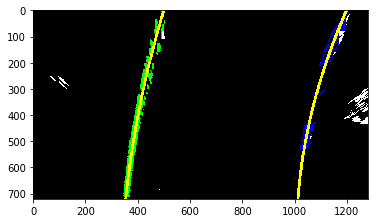

In [34]:
# Visual test of sliding window technique

# Instantiate new Line objects to modify
left_line = Line()
right_line = Line()

# Select an image for testing and display
img = cv2.imread('test_images/test6.jpg')

# Undistort the test image and apply transformations
undistorted = undistort_image(img, c_matrix, dist_coeff)
thresholded = colour_image_transformation_pipeline(undistorted)

# Warp processed test image to new perspective
matrix_transform_inversed_stacked, binary_warped_test = warp_perspective_to_top_down(source_transformation, thresholded[1],
                                                         destination_transformation)

# Modify Line objects by applying sliding window technique for active pixels
offset_from_center, left_line, right_line, y_axis_values = setup_lines(binary_warped_test, left_line,
                                                                       right_line)

# Best fit the left and right lines
best_left_fit_x, y_axis_values, best_right_fit_x = calc_deg_2_polynomial_with_left_right_fit_x_coefficients(
    binary_warped_test,
    left_line.current_fit,
    right_line.current_fit)

# Highlight pixels in green (left) and blue (right) on test image
out_img = highlight_detected_line_pixels(binary_warped_test, left_line, right_line)

# Get the x, y plotting coordinates
left_points, right_points = create_x_y_line_coordinates(left_line, right_line, y_axis_values)

# Iteratively plot left, right polynomial points to make yellow lines
draw_polynomial_line(left_points)
draw_polynomial_line(right_points)

# Save result and plot to screen
plt.imsave('output_images/polynomial_fitted.jpg', out_img)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img)


### 6.2 ... vehicle position with respect to center.

In [35]:
def check_lane_lines_are_parallel(left_line_fit_x, right_line_fit_x):
    """
    Check that the difference in line absolute values is less than 100.
    :param left_line_fit_x: Fitted left line.
    :param right_line_fit_x: Fitted right line.
    :return: True if check passes, else False.
    """
    if abs((right_line_fit_x[0] - left_line_fit_x[0]) - (right_line_fit_x[-1] - left_line_fit_x[-1])) < 100:
        return True
    else:
        return False



In [36]:
def check_lane_lines_have_expected_distance(left_line_fit_x, right_line_fit_x):
    """
    Check distance between left and right top-down projected lines is within range.
    Range gives allowance for fanning out of top of lines.
    :param left_line_fit_x: Fitted left line.
    :param right_line_fit_x: Fitted right line.
    :return: True if check passes, else False.
    """
    if (570 < (right_line_fit_x[0] - left_line_fit_x[0]) < 820) and (
                    570 < (right_line_fit_x[-1] - left_line_fit_x[-1]) < 820):
        return True
    else:
        return False



In [37]:
def find_lane_polynomial_indices_within_window_margins(active_pxs_x, active_pxs_y, left_fit, right_fit,
                                                       window_width_margin):
    """
    Calculate degree-2 polynomial left / right fit for active x / y pixels within a window margin

    e.g. p(x) = p[0]        *  x            **deg + p[1]        * x            + p[deg]      +/- window_width_margin
                left_fit[0] * (active_pxs_y ** 2) + left_fit[1] * active_pxs_y + left_fit[2] +/- window_width_margin

    :param active_pxs_x: active pixels in x direction
    :param active_pxs_y: active pixels in y direction
    :param left_fit: best fit left line positions
    :param right_fit: best fit right line positions
    :param window_width_margin: sliding window width margin range to search within
    :return: new left / right lane line pixel positions
    """
    left_lane_inds = (
        (active_pxs_x > (
            left_fit[0] * (active_pxs_y ** 2) + left_fit[1] * active_pxs_y + left_fit[
                2] - window_width_margin)) & (
            active_pxs_x < (left_fit[0] * (active_pxs_y ** 2) + left_fit[1] * active_pxs_y + left_fit[
                2] + window_width_margin)))
    right_lane_inds = (
        (active_pxs_x > (right_fit[0] * (active_pxs_y ** 2) + right_fit[1] * active_pxs_y + right_fit[
            2] - window_width_margin)) & (
            active_pxs_x < (right_fit[0] * (active_pxs_y ** 2) + right_fit[1] * active_pxs_y + right_fit[
                2] + window_width_margin)))
    return left_lane_inds, right_lane_inds



In [38]:
def search_and_update_lines(binary_warped, left_line_obj, right_line_obj, max_line_history):
    """
    Search and update lines in new image frame using iterative sliding window technique
    :param binary_warped: top-down perspective of lane lines to operate on
    :param left_line_obj: Line object to modify
    :param right_line_obj: Line object to modify
    :param max_line_history: history of recently fitted line positions
    :return: modified lines, vehicle offset from lane centre, y_axis number series 0 - 719
    """
    # Ensure lines have already been setup
    if len(left_line_obj.recent_xfitted) or len(right_line_obj.recent_xfitted) == 0:
        offset_from_center, left_line_obj, right_line_obj, y_axis = setup_lines(binary_warped, left_line_obj,
                                                                                right_line_obj)

    # Reference the current fit
    left_fit = left_line_obj.current_fit
    right_fit = right_line_obj.current_fit

    # Get the active pixels from the top-down view
    active_pixels_x, active_pixels_y = find_active_x_y_pixels(binary_warped)

    # Set the window margin range to apply polynomial within
    window_width_margin = 20

    # Fit polynomials and get the line positions
    left_lane_indices, right_lane_indices = find_lane_polynomial_indices_within_window_margins(active_pixels_x,
                                                                                               active_pixels_y,
                                                                                               left_fit,
                                                                                               right_fit,
                                                                                               window_width_margin)

    # Group active pixels    
    left_x_pixels, left_y_pixels, right_x_pixels, right_y_pixels = group_active_x_y_pixels(active_pixels_x,
                                                                                           active_pixels_y,
                                                                                           left_lane_indices,
                                                                                           right_lane_indices)

    # Fit a degree-2 polynomial to left and right zones
    left_fit = np.polyfit(left_y_pixels, left_x_pixels, 2)
    right_fit = np.polyfit(right_y_pixels, right_x_pixels, 2)

    # Best fit the left and right lines
    left_fitx, y_axis_values, right_fitx = calc_deg_2_polynomial_with_left_right_fit_x_coefficients(
        binary_warped,
        left_fit,
        right_fit)

    # Sanity checking
    if (check_lane_lines_are_parallel(left_fitx, right_fitx) and check_lane_lines_have_expected_distance(
            left_fitx, right_fitx)):
        left_line_obj.recent_xfitted.append(left_fitx)
        right_line_obj.recent_xfitted.append(right_fitx)

        # Truncate store to maximum line history
        if len(left_line_obj.recent_xfitted) > max_line_history:
            np.delete(left_line_obj.recent_xfitted, 0)
            np.delete(right_line_obj.recent_xfitted, 0)

        # Smooth best x points
        left_line_obj.bestx = np.average(left_line_obj.recent_xfitted, axis=0)
        right_line_obj.bestx = np.average(right_line_obj.recent_xfitted, axis=0)

        # Update Line objects attributes
        left_line_obj.allx = left_x_pixels
        left_line_obj.ally = left_y_pixels
        right_line_obj.allx = right_x_pixels
        right_line_obj.ally = right_y_pixels

        # Update current fit
        left_line_obj.current_fit = left_fit
        right_line_obj.current_fit = right_fit

    else:  # lines not parallel and not expected distance
        left_line_obj.failed_sanity_check_count = + 1
        if (left_line_obj.failed_sanity_check_count > 60):  # may have lost sight of lane lines. Reset now.
            offset_from_center, left_line_obj, right_line_obj, y_axis = setup_lines(binary_warped,
                                                                                    left_line_obj,
                                                                                    right_line_obj)
            left_line_obj.failed_sanity_check_count = 0

    offset_from_center = get_offset_from_center(right_fitx[0], left_fitx[0], binary_warped.shape[1] / 2)

    return offset_from_center, left_line_obj, right_line_obj, y_axis_values



In [39]:
offset_from_center, left_line, right_line, y_axis_vals = search_and_update_lines(top_down_warped_binary_stacked,
                                                                                 left_line,
                                                                                 right_line, 20)


In [40]:
def convert_and_calc_curvature_radii(left_line_obj, right_line_obj, y_axis_values):
    """
    Convert x, y from pixels to metres, calc new left and right lane radii
    :param left_line_obj: access the Line object attributes
    :param right_line_obj: access the Line object attributes
    :param y_axis_values: number series from 0 - 719 representing image y-axis
    :return: curve radii
    """
    # Get latest line attributes
    left_x = left_line_obj.allx
    left_y = left_line_obj.ally
    right_x = right_line_obj.allx
    right_y = right_line_obj.ally

    # Calc metres per pixel of lane length and width
    y_metres_per_pix = 30 / 720  # metres per pixel calc
    x_metres_per_pix = 3.7 / 700  # metres per pixel calc

    # Get bottom of image from y values aka 719
    y_max = np.max(y_axis_values)

    # Calc and least squares error fit the degree-2 polynomials
    left_fit_metres_per_pixel = np.polyfit(left_y * y_metres_per_pix, left_x * x_metres_per_pix, 2)
    right_fit_metres_per_pixel = np.polyfit(right_y * y_metres_per_pix, right_x * x_metres_per_pix, 2)

    # Calc new curvature radius for left and right
    left_curve_radius = ((1 + (
        2 * left_fit_metres_per_pixel[0] * y_max * y_metres_per_pix + left_fit_metres_per_pixel[
            1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_metres_per_pixel[0])
    right_curve_radius = ((1 + (
        2 * right_fit_metres_per_pixel[0] * y_max * y_metres_per_pix + right_fit_metres_per_pixel[
            1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_metres_per_pixel[0])
    
    # print("left_curve_radius :", "{0:.0f}".format(left_curve_radius), "metres")  # left_curve_radius : 2263 metres
    # print("right_curve_radius :", "{0:.0f}".format(right_curve_radius), "metres")  # right_curve_radius : 6813 metres
    return left_curve_radius, right_curve_radius



In [41]:
convert_and_calc_curvature_radii(left_line, right_line, y_axis_vals)



(2262.6079272543384, 6812.9751622872072)

### 7. Warp the detected lane boundaries back onto the original image.

In [42]:
def create_image_base(dist, dst, img, left_line_obj, mtx, result, right_line_obj, src):
    """
    Colour base image used to draw lane polygon onto

    :param dist: distortion coefficients
    :param dst: destination points where warp transforms to
    :param img: stacked binary thresholded image that includes saturation, gradient direction, colour intensity
    :param left_line_obj:
    :param mtx: camera attributes matrix
    :param result: grad_sat_bin_image and stacked_s_g_c_bin_image from colour_image_transformation_pipeline
    :param right_line_obj:
    :param src: source points where warp transforms from
    :return: warped colour image
    """
    left_fit_x = left_line_obj.recent_xfitted[-1]  # most recent fitted line
    right_fit_x = right_line_obj.recent_xfitted[-1]  # most recent fitted line
    undistorted = undistort_image(img, mtx, dist)
    matrix_transform_inversed_stacked, binary_warped = warp_perspective_to_top_down(src, result[1], dst)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    colour_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    return colour_warp, left_fit_x, matrix_transform_inversed_stacked, right_fit_x, undistorted



In [43]:
def draw_filled_polygon(img, mtx, dist, src, result, dst, y_axis_values, left_line_obj, right_line_obj):
    """
    Project green filled fitted polygon onto undistorted image.

    :param img: stacked binary thresholded image that includes saturation, gradient direction, colour intensity
    :param mtx: camera attributes matrix
    :param dist: distortion coefficients
    :param src: source points where warp transforms from
    :param result: grad_sat_bin_image and stacked_s_g_c_bin_image from colour_image_transformation_pipeline
    :param dst: destination points where warp transforms to
    :param y_axis_values: number series from 0 - 719 representing image y-axis
    :param left_line_obj: access the Line object attributes
    :param right_line_obj: access the Line object attributes
    :return: overlay inverted colour warp with filled polygon ontop of undistorted image
    """
    # Create image to draw lines onto
    colour_warp, left_fit_x, matrix_transform_inversed_stacked, right_fit_x, undistorted = create_image_base(
        dist, dst, img, left_line_obj, mtx, result, right_line_obj, src)

    # Transpose x and y points for cv2.fillPoly() use
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, y_axis_values]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, y_axis_values])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw green lane onto warped base image
    cv2.fillPoly(colour_warp, np.int_([pts]), (0, 255, 0))

    # Warp the base back to original perspective using inverse perspective matrix
    original_perspective = cv2.warpPerspective(colour_warp, matrix_transform_inversed_stacked,
                                               (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, original_perspective, 0.3, 0)
    return result



### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [44]:
font = cv2.FONT_HERSHEY_SIMPLEX


In [45]:
def image_labels(img, left_curve_rad, right_curve_rad, offset_from_centre, left_line_obj, right_line_obj):
    """
    Puts labels on image showing curves radii and vehicle position relative to lane centre.
    :param img: image with filled polygon lane
    :param left_curve_rad: left radius length
    :param right_curve_rad: right radius length
    :param offset_from_centre: metres vehicle is from lane centre
    :param left_line_obj: access Line object attributes
    :param right_line_obj: access Line object attributes
    """
    left_curve_rad = int(left_curve_rad)
    right_curve_rad = int(right_curve_rad)
    offset_from_centre = offset_from_centre
    text1 = "Left curve radius = " + str(left_curve_rad) + ' metres , right = ' + str(right_curve_rad)
    text2 = "Vehicle is " + str(offset_from_centre) + ' metres from lane centre'
    text3 = "bottom = " + str(
        right_line_obj.recent_xfitted[-1][0] - left_line_obj.recent_xfitted[-1][0]) + ' top  = ' + str(
        right_line_obj.recent_xfitted[-1][-1] - left_line_obj.recent_xfitted[-1][-1])
    cv2.putText(img, text1, (10, 100), font, 1, (255, 255, 255), 2)
    cv2.putText(img, text2, (10, 130), font, 1, (255, 255, 255), 2)



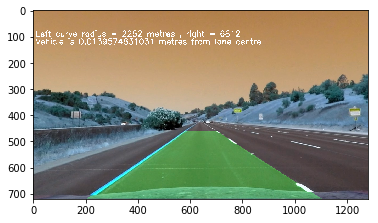

In [46]:
# Visually test an image and store results
left_curverad, right_curverad = convert_and_calc_curvature_radii(left_line, right_line, y_axis_vals)

laned_image = draw_filled_polygon(straight_lines_image, c_matrix, dist_coeff, source_transformation, result,
                                  destination_transformation, y_axis_vals, left_line, right_line)
image_labels(laned_image, left_curverad, right_curverad, offset_from_center, left_line, right_line)

cv2.imwrite('output_images/laned_image.jpg', laned_image)

plt.imshow(laned_image)


In [47]:
img = cv2.imread('test_images/straight_lines1.jpg')
prev_warp = None
left_line = Line()
right_line = Line()


In [48]:
def Pipeline(img, mtx, dist, left_line_obj, right_line_obj):
    """
    Image processing pipeline.
    
    :param img: new frame image
    :param mtx: camera attributes matrix
    :param dist: destination points where warp transforms to
    :param left_line_obj: access the Line object attributes
    :param right_line_obj: access the Line object attributes
    :return: laned image
    """
    # Undistort new image
    undistorted = undistort_image(img, mtx, dist)

    # Apply vision tranformations
    result = colour_image_transformation_pipeline(undistorted)

    # Flip to top-down perspective
    matrix_transform_inversed_stacked, warped = warp_perspective_to_top_down(source_transformation, result[1],
                                                                             destination_transformation)

    # Update lines using sliding windows technique
    offset_from_center, left_line_obj, right_line_obj, y_axis = search_and_update_lines(warped, left_line_obj,
                                                                                        right_line_obj, 60)

    # Project filled green polygon
    laned_image = draw_filled_polygon(undistorted, mtx, dist, source_transformation, result,
                                      destination_transformation,
                                      y_axis, left_line_obj, right_line_obj)

    # Calculate and left / right radii and apply to image
    left_curverad, right_curverad = convert_and_calc_curvature_radii(left_line_obj, right_line_obj, y_axis)

    # Apply calculation results to image
    image_labels(laned_image, left_curverad, right_curverad, offset_from_center, left_line_obj,
                 right_line_obj)
    return laned_image



In [49]:
def process_image(img):
    """
    Reference called by VideoFileClip processor
    :param img: new frame to process
    :return: processed image to render
    """
    result = Pipeline(img, c_matrix, dist_coeff, left_line, right_line)
    return result



In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video processed.mp4
[MoviePy] Writing video processed.mp4


100%|█████████▉| 1260/1261 [03:05<00:00,  6.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed.mp4 

CPU times: user 12min 53s, sys: 2.45 s, total: 12min 55s
Wall time: 3min 5s
